In [30]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost
import tensorflow as tf
import sklearn
import sys, os
import requests
import time
import math

In [31]:
df = pd.read_csv('random_locations.csv') # 8395 data points per location
print(len(df)/8395, 'random locations')
print(len(df), 'data points')
df.sample(n=10)

30.0 random locations
251850 data points


,Unnamed: 0,Year,Month,Day,Hour,Minute,Temperature,Clearsky DHI,Clearsky DNI,Clearsky GHI,...,Surface Albedo,Pressure,Precipitable Water,Wind Direction,Wind Speed,Latitude,Longitude,Elevation,Day Number,Time
216772,12825,2004,9,25,4,30,8.0,0,0,0,...,0.158,940,1.559,212.9,3.2,47.01,-101.50,670,268,270
122758,6680,2019,5,20,4,0,1.6,0,0,0,...,0.100,853,1.000,21.0,1.0,48.01,-120.02,1200,140,240
81741,15171,2009,11,13,1,30,13.0,0,0,0,...,0.147,930,1.762,195.5,5.5,37.01,-99.02,551,317,90
242480,838,2015,1,18,11,0,4.0,62,722,259,...,0.866,930,1.178,226.5,0.6,49.01,-116.50,569,18,660
196482,13006,2009,9,28,23,0,16.0,0,0,0,...,0.217,840,1.048,239.5,2.0,36.01,-111.50,1499,271,1380
42767,10260,2004,8,2,18,0,29.0,56,535,182,...,0.186,1000,1.867,205.3,3.0,39.01,-122.02,20,214,1080
169784,16866,2000,12,18,9,0,0.0,57,669,205,...,0.866,970,0.618,330.9,8.0,37.01,-97.02,349,352,540
201605,13507,2016,10,9,9,30,19.0,94,857,593,...,0.193,860,1.628,226.1,0.8,38.49,-103.50,1396,282,570
9661,2634,2013,2,24,21,0,-6.0,0,0,0,...,0.866,850,0.515,223.5,3.5,43.01,-113.02,1499,55,1260
12701,3032,2007,3,5,4,0,-2.0,0,0,0,...,0.866,850,0.852,116.7,1.1,43.01,-113.02,1499,64,240


# Data Transformation

In [32]:
df.columns

Index(['Unnamed: 0', 'Year', 'Month', 'Day', 'Hour', 'Minute', 'Temperature',
       'Clearsky DHI', 'Clearsky DNI', 'Clearsky GHI', 'Cloud Type',
       'Dew Point', 'DHI', 'DNI', 'Fill Flag', 'GHI', 'Relative Humidity',
       'Solar Zenith Angle', 'Surface Albedo', 'Pressure',
       'Precipitable Water', 'Wind Direction', 'Wind Speed', 'Latitude',
       'Longitude', 'Elevation', 'Day Number', 'Time'],
      dtype='object')

In [33]:
df.dtypes

Unnamed: 0              int64
Year                    int64
Month                   int64
Day                     int64
Hour                    int64
Minute                  int64
Temperature           float64
Clearsky DHI            int64
Clearsky DNI            int64
Clearsky GHI            int64
Cloud Type              int64
Dew Point             float64
DHI                     int64
DNI                     int64
Fill Flag               int64
GHI                     int64
Relative Humidity     float64
Solar Zenith Angle    float64
Surface Albedo        float64
Pressure                int64
Precipitable Water    float64
Wind Direction        float64
Wind Speed            float64
Latitude              float64
Longitude             float64
Elevation               int64
Day Number              int64
Time                    int64
dtype: object

Logically, the minute column is only relevant when combined with the hour—that is, we know the time in a unified format. For this purpose, we decided to calculate time in terms of minutes; however, we could've also taken the 24-hour approach\
Moreover, we also need to combine the day and month columns to achive a useful metric; we do so by creating a week column

In [34]:
def weekCalculator(month, day):
    month_to_days = {}
    month_to_days[1] = 0
    month_to_days[2] = 31
    month_to_days[3] = 28
    month_to_days[4] = 31
    month_to_days[5] = 30
    month_to_days[6] = 31
    month_to_days[7] = 30
    month_to_days[8] = 31
    month_to_days[9] = 31
    month_to_days[10] = 30
    month_to_days[11] = 31
    month_to_days[12] = 30
    
    total_days = 0
    for i in range(1, month+1):
        total_days = total_days + month_to_days[i]
    total_days = total_days + day
    week_number = int(total_days/7) + 1
    return week_number

In [35]:
def dayCalculator(month, day):
    month_to_days = {}
    month_to_days[1] = 0
    month_to_days[2] = 31
    month_to_days[3] = 28
    month_to_days[4] = 31
    month_to_days[5] = 30
    month_to_days[6] = 31
    month_to_days[7] = 30
    month_to_days[8] = 31
    month_to_days[9] = 31
    month_to_days[10] = 30
    month_to_days[11] = 31
    month_to_days[12] = 30
    
    total_days = 0
    for i in range(1, month+1):
        total_days = total_days + month_to_days[i]
    total_days = total_days + day
    return total_days

In [36]:
df['Day Number'] = df.apply(lambda df : dayCalculator(int(df['Month']), int(df['Day'])), axis = 1)
df['Week'] = df.apply(lambda df : weekCalculator(int(df['Month']), int(df['Day'])), axis = 1)
df['Time'] = df['Hour']*60 + df['Minute']

Lastly, we can calculate specfiic humidity using relative humidity, temperature, and pressure to reduce the number of features in our model

In [37]:
def sh(rh, temp, p):
    # pressure in millibar
    # temp in C
    # rh in percent
    # precipitable water in millimeter (mm)
    p_Pa = p*100 # in Pa
    exponent_factor = math.exp((17.625*temp)/(temp+243.08))
    sh_val = (rh*3800*exponent_factor)/p_Pa
    return sh_val

In [38]:
df['Specific Humidity'] = df.apply(lambda df : sh(float(df['Relative Humidity']), float(df['Temperature']), float(df['Pressure'])), axis = 1)


In [39]:
df_controlled = df.filter(['Latitude', 'Longitude', 'Elevation', 'Year', 'Day Number','Time','Temperature', 'Solar Zenith Angle', 'Surface Albedo', 'Cloud Type', 'Relative Humidity', 'Pressure', 'Specific Humidity', 'Clearsky DHI', 'Clearsky DNI', 'Clearsky GHI', 'DHI', 'DNI', 'GHI', 'Dew Point', 'Fill Flag', 'Wind Direction', 'Wind Speed', 'Precipitable Water'], axis=1)


# Model Building

1. Fix categorical variables => no categorical variables
2. Think if any other variables impact precipitable water => **unsure**; however, looks complete

## Baseline (Linear Regression)

In [40]:
train, test = sklearn.model_selection.train_test_split(df_controlled, test_size=0.2, random_state = 4)
x_train = train[['Specific Humidity']]
y_train = train[['Precipitable Water']]
x_test = test[['Specific Humidity']]
y_test = test[['Precipitable Water']]

In [41]:
from sklearn import linear_model
linear_regression = linear_model.LinearRegression()
linear_regression.fit(x_train, y_train)

LinearRegression()

In [42]:
y_predicted = linear_regression.predict(x_test)

Text(0.5, 1.0, 'Linear Regression')

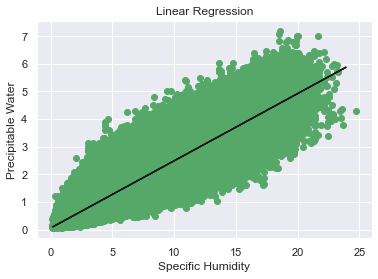

In [43]:
plt.scatter(x_train, y_train,color='g') 
plt.plot(x_test, y_predicted,color='k') 
plt.xlabel('Specific Humidity')
plt.ylabel('Precipitable Water')
plt.title('Linear Regression')

In [44]:
from sklearn import metrics

print('R-squared:', metrics.r2_score(y_test, y_predicted))
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_predicted))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_predicted))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_predicted)))

R-squared: 0.8443310783469571
Mean Absolute Error: 0.3411602390413592
Mean Squared Error: 0.21669253459424304
Root Mean Squared Error: 0.465502453907864


In [45]:
df_test = pd.read_csv('random_location_1.csv')
df_test['Specific Humidity'] = df_test.apply(lambda df_test : sh(float(df_test['Relative Humidity']), float(df_test['Temperature']), float(df_test['Pressure'])), axis = 1)
x_true_test = df_test[['Specific Humidity']]
df_test['Prediction'] = linear_regression.predict(x_true_test)
print('R-squared:', metrics.r2_score(df_test['Precipitable Water'], df_test['Prediction']))

R-squared: 0.8244000234914897


Text(0.5, 1.0, 'Predciting PW using SH (Unseen)')

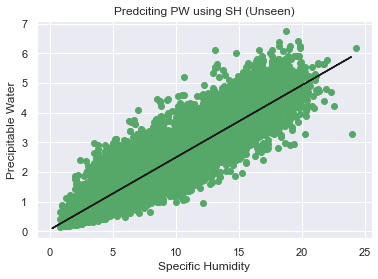

In [46]:
plt.scatter(df_test['Specific Humidity'], df_test['Precipitable Water'],color='g') 
plt.plot(x_test, y_predicted,color='k') 
plt.xlabel('Specific Humidity')
plt.ylabel('Precipitable Water')
plt.title('Predciting PW using SH (Unseen)')

## Random Forest

In [47]:
train, test = sklearn.model_selection.train_test_split(df_controlled, test_size=0.2, random_state = 4)
x_train = train[['Latitude', 'Longitude', 'Elevation', 'Day Number', 'Time', 'Solar Zenith Angle', 'Specific Humidity', 'Pressure', 'Temperature', 'Wind Direction', 'Wind Speed', 'DHI' , 'DNI']] # AA
# x_train = train[['Latitude', 'Longitude', 'Elevation', 'Day Number', 'Time', 'Solar Zenith Angle', 'Surface Albedo', 'Relative Humidity', 'Pressure', 'Temperature', 'Cloud Type', 'Clearsky DHI', 'Clearsky DNI', 'Clearsky GHI', 'Dew Point', 'Wind Direction', 'Wind Speed', 'Fill Flag', 'DHI' , 'DNI', 'GHI', 'Specific Humidity']]
y_train = train[['Precipitable Water']]

x_test = test[['Latitude', 'Longitude', 'Elevation', 'Day Number', 'Time', 'Solar Zenith Angle', 'Specific Humidity', 'Pressure', 'Temperature', 'Wind Direction', 'Wind Speed', 'DHI' , 'DNI']] # AA
# x_test = test[['Latitude', 'Longitude', 'Elevation', 'Day Number', 'Time', 'Solar Zenith Angle', 'Surface Albedo', 'Relative Humidity', 'Pressure', 'Temperature', 'Cloud Type', 'Clearsky DHI', 'Clearsky DNI', 'Clearsky GHI', 'Dew Point', 'Wind Direction', 'Wind Speed', 'Fill Flag', 'DHI' , 'DNI', 'GHI', 'Specific Humidity']]
y_test = test[['Precipitable Water']]
# https://www.quora.com/Does-Decision-Tree-assume-variables-are-all-independent-as-it-is-a-nonparametric-method

In [48]:
print(len(x_train))
print(len(x_test))

201480
50370


In [49]:
from sklearn.ensemble import RandomForestRegressor
forest_regression_full = RandomForestRegressor()
forest_regression_full.fit(x_train, y_train.values.ravel())

RandomForestRegressor()

In [50]:
y_predicted = forest_regression_full.predict(x_test)

In [51]:
from sklearn import metrics

print('R-squared:', metrics.r2_score(y_test, y_predicted))
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_predicted))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_predicted))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_predicted)))
print('RMSE represents the square root of the variance of the residuals')

R-squared: 0.8985028204034284
Mean Absolute Error: 0.26981019178082194
Mean Squared Error: 0.14128498397366684
Root Mean Squared Error: 0.37587894856411797
RMSE represents the square root of the variance of the residuals


In [52]:
df_test = pd.read_csv('random_location_10.csv')
df_test['Specific Humidity'] = df_test.apply(lambda df_test : sh(float(df_test['Relative Humidity']), float(df_test['Temperature']), float(df_test['Pressure'])), axis = 1)
x_true_test = df_test[['Latitude', 'Longitude', 'Elevation', 'Day Number', 'Time', 'Solar Zenith Angle', 'Specific Humidity', 'Pressure', 'Temperature', 'Wind Direction', 'Wind Speed', 'DHI' , 'DNI']] # AA
# x_true_test = df_test[['Latitude', 'Longitude', 'Elevation', 'Day Number', 'Time', 'Solar Zenith Angle', 'Surface Albedo', 'Relative Humidity', 'Pressure', 'Temperature', 'Cloud Type', 'Clearsky DHI', 'Clearsky DNI', 'Clearsky GHI', 'Dew Point', 'Wind Direction', 'Wind Speed', 'Fill Flag', 'DHI' , 'DNI', 'GHI', 'Specific Humidity']]
df_test['Prediction'] = forest_regression_full.predict(x_true_test)
print('R-squared:', metrics.r2_score(df_test['Precipitable Water'], df_test['Prediction']))

R-squared: 0.8215619648670117


### SP-LIME

In [53]:
import warnings
from lime import submodular_pick
import lime.lime_tabular
import lime

In [54]:
categorical_features = np.argwhere(np.array ([ len(set(x_train.iloc[:,x])) for x in range(x_train.shape[1]) ]) <= 10
                                  ).flatten()

In [55]:
explainer = lime.lime_tabular.LimeTabularExplainer(
    x_train.values, 
    feature_names=x_train.columns,
    class_names=['Precipitable Water'], 
    categorical_features=categorical_features, 
    verbose=True, 
    mode='regression'
)

In [56]:
sp_obj = submodular_pick.SubmodularPick(
    explainer, 
    x_train.values, 
    forest_regression_full.predict, 
    sample_size=10, 
    num_features=22, 
    num_exps_desired=10)

/Users/architg/miniforge3/envs/tf_m1/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Intercept 1.126710554425653
Prediction_local [3.54025937]
Right: 3.87825


/Users/architg/miniforge3/envs/tf_m1/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Intercept 1.1167782278049718
Prediction_local [3.20697219]
Right: 3.441689999999998


/Users/architg/miniforge3/envs/tf_m1/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Intercept 1.977067509382936
Prediction_local [1.06766113]
Right: 1.1519200000000005


/Users/architg/miniforge3/envs/tf_m1/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Intercept 1.6855016491998185
Prediction_local [1.96496272]
Right: 1.8313799999999991


/Users/architg/miniforge3/envs/tf_m1/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Intercept 2.1416456587174917
Prediction_local [0.49765981]
Right: 0.7615500000000004


/Users/architg/miniforge3/envs/tf_m1/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Intercept 2.0253671968897637
Prediction_local [0.8353842]
Right: 0.6992300000000009


/Users/architg/miniforge3/envs/tf_m1/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Intercept 1.5381482597100467
Prediction_local [1.94173362]
Right: 1.5721199999999989


/Users/architg/miniforge3/envs/tf_m1/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Intercept 1.1077726742769944
Prediction_local [3.27741542]
Right: 2.2659399999999987


/Users/architg/miniforge3/envs/tf_m1/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Intercept 1.2328313885575752
Prediction_local [3.26176009]
Right: 2.397759999999999


/Users/architg/miniforge3/envs/tf_m1/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Intercept 1.2100228627479996
Prediction_local [3.27294105]
Right: 2.5027500000000047


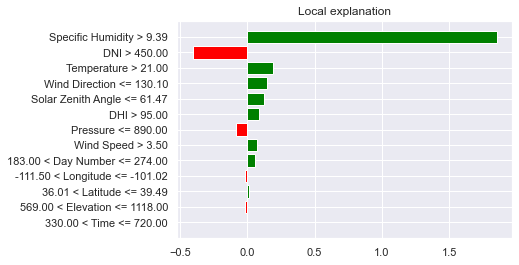

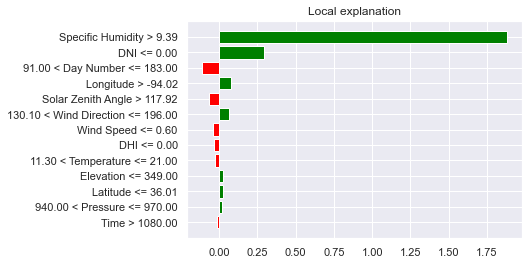

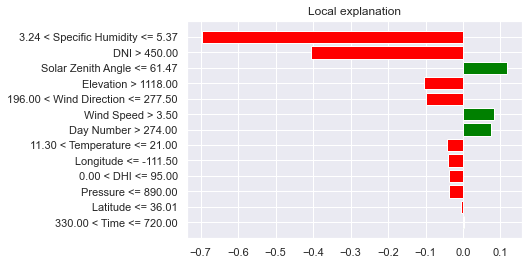

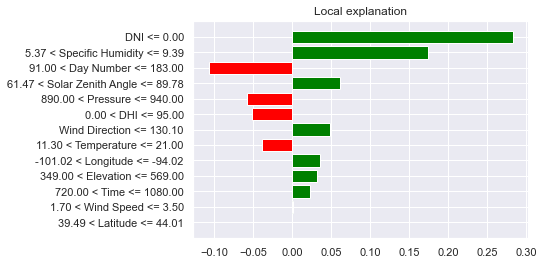

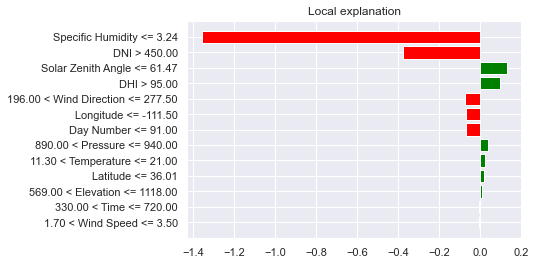

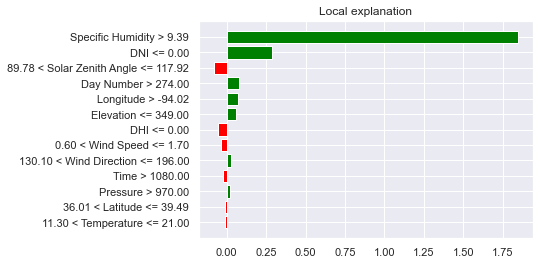

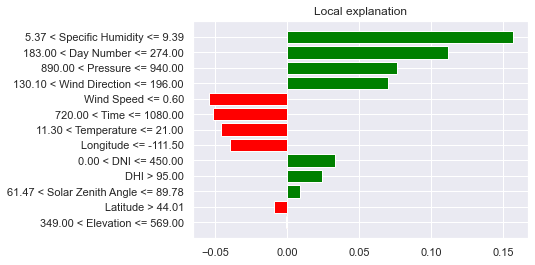

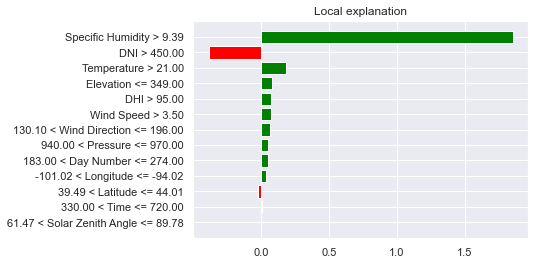

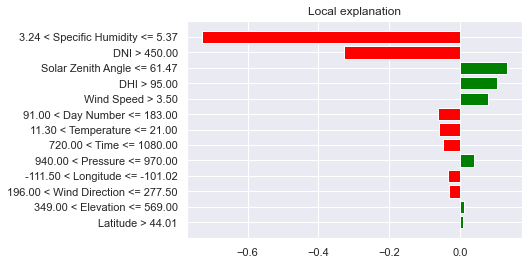

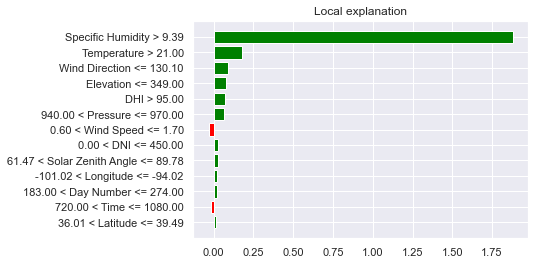

In [57]:
[exp.as_pyplot_figure() for exp in sp_obj.sp_explanations];

In [58]:
impact_variables = {}
impact_variables['SpecificHumidity'] = 0
impact_variables['DewPoint'] = 0
impact_variables['CloudType'] = 0
impact_variables['DayNumber'] = 0
impact_variables['FillFlag'] = 0
impact_variables['WindDirection'] = 0
impact_variables['Latitude'] = 0
impact_variables['Longitude'] = 0
impact_variables['Elevation'] = 0
impact_variables['Time'] = 0
impact_variables['SolarZenithAngle'] = 0
impact_variables['SurfaceAlbedo'] = 0
impact_variables['RelativeHumidity'] = 0
impact_variables['Pressure'] = 0
impact_variables['Temperature'] = 0
impact_variables['Pressure'] = 0
impact_variables['ClearskyDHI'] = 0
impact_variables['ClearskyDNI'] = 0
impact_variables['ClearskyGHI'] = 0
impact_variables['WindSpeed'] = 0
impact_variables['DHI'] = 0
impact_variables['DNI'] = 0
impact_variables['GHI'] = 0
len(impact_variables)

22

In [59]:
import re
for exp in sp_obj.sp_explanations:
    for element in exp.as_list():
        old_label = str(element[0])
        label = re.sub(r'[^a-zA-Z]', '', old_label)
        print(label)
        print(abs(element[1]))
        impact_variables[label] = (impact_variables[label] + abs(element[1]))
    print('\n')

SpecificHumidity
1.8536787798574041
DNI
0.40502249535701934
Temperature
0.190560446872101
WindDirection
0.14990000289653962
SolarZenithAngle
0.12599403246974974
DHI
0.08847066447571474
Pressure
0.08668195502377914
WindSpeed
0.0724062563307298
DayNumber
0.058451349613330095
Longitude
0.017345286814569788
Latitude
0.01592025627778119
Elevation
0.0139512539309505
Time
0.003452095660320208


SpecificHumidity
1.8799895015501322
DNI
0.2921809155168149
DayNumber
0.10881061277948635
Longitude
0.07590028443305794
SolarZenithAngle
0.06559531800256856
WindDirection
0.06192594640635744
WindSpeed
0.039876567129563834
DHI
0.0331742863771062
Temperature
0.02549789599187785
Elevation
0.025474296232510026
Latitude
0.02254988565237574
Pressure
0.01975921452717319
Time
0.014631397756319785


SpecificHumidity
0.6951174186221718
DNI
0.40430367191587
SolarZenithAngle
0.11678180412274565
Elevation
0.10504394801492764
WindDirection
0.0998430889294881
WindSpeed
0.08156833018720351
DayNumber
0.07360183832679261

In [60]:
for feature, value in impact_variables.items():
    print(feature, ': ', value)

SpecificHumidity :  12.42783438147154
DewPoint :  0
CloudType :  0
DayNumber :  0.738905102645448
FillFlag :  0
WindDirection :  0.7263259851482265
Latitude :  0.13015530166663541
Longitude :  0.44507641776968165
Elevation :  0.4106674292189496
Time :  0.20110155266812094
SolarZenithAngle :  0.7475963710781802
SurfaceAlbedo :  0
RelativeHumidity :  0
Pressure :  0.48630904560542987
Temperature :  0.7973193003163728
ClearskyDHI :  0
ClearskyDNI :  0
ClearskyGHI :  0
WindSpeed :  0.47410555947421423
DHI :  0.6333046295105712
DNI :  2.8179999619112888
GHI :  0


Obtained after looking through 2000 examples and picking 10 most representative ones

## Compact Random Forest (features picked using SP-LIME)

Features picked in the compact model include 10 variables with the highest impact on the random forest \
Specific Humidity, Dew Point, Cloud Type, Day Number, Fill Flag, Wind Direction, Latitude, Longitude, Elevation, Time

In [61]:
train, test = sklearn.model_selection.train_test_split(df_controlled, test_size=0.2, random_state = 4)

x_train = train[['Specific Humidity', 'Dew Point', 'Cloud Type', 'Day Number', 'Fill Flag', 'Wind Direction', 'Latitude', 'Longitude', 'Elevation', 'Time']]
# x_train = train[['Latitude', 'Longitude', 'Time', 'Day Number', 'Specific Humidity', 'Pressure', 'Temperature', 'GHI']] # AA
# x_train = train[['Elevation' , 'Relative Humidity', 'Pressure', 'Temperature', 'GHI']] # last try 

y_train = train[['Precipitable Water']]


x_test = test[['Specific Humidity', 'Dew Point', 'Cloud Type', 'Day Number', 'Fill Flag', 'Wind Direction', 'Latitude', 'Longitude', 'Elevation', 'Time']]
# x_test = test[['Latitude', 'Longitude', 'Time', 'Day Number', 'Specific Humidity', 'Pressure', 'Temperature', 'GHI']] # AA
# x_test = test[['Elevation' , 'Relative Humidity', 'Pressure', 'Temperature', 'GHI']] # last try 

y_test = test[['Precipitable Water']]

In [62]:
from sklearn.ensemble import RandomForestRegressor
forest_regression_sp = RandomForestRegressor()
forest_regression_sp.fit(x_train, y_train.values.ravel())

RandomForestRegressor()

In [63]:
y_predicted = forest_regression_sp.predict(x_test)

In [64]:
from sklearn import metrics

print('R-squared:', metrics.r2_score(y_test, y_predicted))
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_predicted))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_predicted))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_predicted)))
print('RMSE represents the square root of the variance of the residuals')

R-squared: 0.8969484984196572
Mean Absolute Error: 0.2737539966249752
Mean Squared Error: 0.14344861411038515
Root Mean Squared Error: 0.3787461077164822
RMSE represents the square root of the variance of the residuals


In [65]:
df_test = pd.read_csv('random_location_1.csv')
df_test['Specific Humidity'] = df_test.apply(lambda df_test : sh(float(df_test['Relative Humidity']), float(df_test['Temperature']), float(df_test['Pressure'])), axis = 1)

x_true_test = df_test[['Specific Humidity', 'Dew Point', 'Cloud Type', 'Day Number', 'Fill Flag', 'Wind Direction', 'Latitude', 'Longitude', 'Elevation', 'Time']]
# x_true_test = df_test[['Latitude', 'Longitude', 'Time', 'Day Number', 'Specific Humidity', 'Pressure', 'Temperature', 'GHI']] # AA
# x_true_test = df_test[['Elevation' , 'Relative Humidity', 'Pressure', 'Temperature', 'GHI']] # last try 

df_test['Prediction'] = forest_regression_sp.predict(x_true_test)
print('R-squared:', metrics.r2_score(df_test['Precipitable Water'], df_test['Prediction']))

R-squared: 0.8771855780913251


## Compact Random Forest (features picked using Physics)

https://www.engr.colostate.edu/~ramirez/ce_old/classes/cive322-Ramirez/CE322_Web/PrecipitableWaterExample.html

In [66]:
train, test = sklearn.model_selection.train_test_split(df_controlled, test_size=0.2, random_state = 4)

x_train = train[['Elevation', 'Temperature', 'Pressure', 'Specific Humidity']]
y_train = train[['Precipitable Water']]

x_test = test[['Elevation', 'Temperature', 'Pressure', 'Specific Humidity']]
y_test = test[['Precipitable Water']]

In [67]:
from sklearn.ensemble import RandomForestRegressor
forest_regression_physics = RandomForestRegressor()
forest_regression_physics.fit(x_train, y_train.values.ravel())

RandomForestRegressor()

In [68]:
y_predicted = forest_regression_physics.predict(x_test)

In [69]:
from sklearn import metrics

print('R-squared:', metrics.r2_score(y_test, y_predicted))
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_predicted))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_predicted))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_predicted)))
print('RMSE represents the square root of the variance of the residuals')

R-squared: 0.8482125352415714
Mean Absolute Error: 0.33380237694978093
Mean Squared Error: 0.2112895117976511
Root Mean Squared Error: 0.4596623889308882
RMSE represents the square root of the variance of the residuals


In [70]:
df_test = pd.read_csv('random_location_10.csv')
df_test['Specific Humidity'] = df_test.apply(lambda df_test : sh(float(df_test['Relative Humidity']), float(df_test['Temperature']), float(df_test['Pressure'])), axis = 1)
x_true_test = df_test[['Elevation', 'Temperature', 'Pressure', 'Specific Humidity']]
df_test['Prediction'] = forest_regression_physics.predict(x_true_test)
print('R-squared:', metrics.r2_score(df_test['Precipitable Water'], df_test['Prediction']))

R-squared: 0.7430078241275404


## Multivariate Regression

In [71]:
train, test = sklearn.model_selection.train_test_split(df_controlled, test_size=0.2, random_state = 4)

x_train = train[['Specific Humidity', 'Dew Point', 'Cloud Type', 'Day Number', 'Fill Flag', 'Wind Direction', 'Latitude', 'Longitude', 'Elevation', 'Time']]
y_train = train[['Precipitable Water']]

x_test = test[['Specific Humidity', 'Dew Point', 'Cloud Type', 'Day Number', 'Fill Flag', 'Wind Direction', 'Latitude', 'Longitude', 'Elevation', 'Time']]
y_test = test[['Precipitable Water']]

In [72]:
from sklearn import linear_model
multivariate_linear_regression = linear_model.LinearRegression()
multivariate_linear_regression.fit(x_train, y_train)

LinearRegression()

In [73]:
y_predicted = multivariate_linear_regression.predict(x_test)

In [74]:
from sklearn import metrics

print('R-squared:', metrics.r2_score(y_test, y_predicted))
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_predicted))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_predicted))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_predicted)))

R-squared: 0.8630183286974404
Mean Absolute Error: 0.322103205459461
Mean Squared Error: 0.1906797145654081
Root Mean Squared Error: 0.43666888435679513


In [75]:
df_test = pd.read_csv('random_location_1.csv')
df_test['Specific Humidity'] = df_test.apply(lambda df_test : sh(float(df_test['Relative Humidity']), float(df_test['Temperature']), float(df_test['Pressure'])), axis = 1)
x_true_test = df_test[['Specific Humidity', 'Dew Point', 'Cloud Type', 'Day Number', 'Fill Flag', 'Wind Direction', 'Latitude', 'Longitude', 'Elevation', 'Time']]
df_test['Prediction'] = multivariate_linear_regression.predict(x_true_test)
print('R-squared:', metrics.r2_score(df_test['Precipitable Water'], df_test['Prediction']))

R-squared: 0.8483356386083949


# Graphs

## Data

In [76]:
import seaborn as sns
from matplotlib import pyplot as plt

Text(18.21, 0.5, 'Precipitable Water')

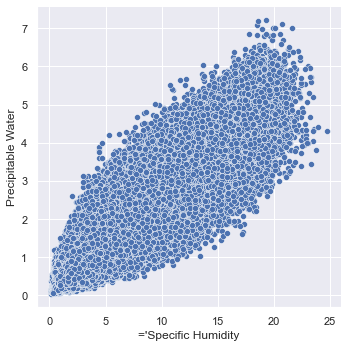

In [77]:
sns.relplot(x='Specific Humidity', y='Precipitable Water', data = df_controlled)
plt.xlabel("Specific Humidity")
plt.ylabel("Precipitable Water")

Text(18.21, 0.5, 'Precipitable Water')

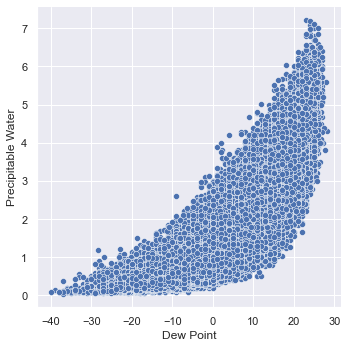

In [78]:
sns.relplot(x='Dew Point', y='Precipitable Water', data = df_controlled)
plt.xlabel("Dew Point")
plt.ylabel("Precipitable Water")

Text(18.21, 0.5, 'Precipitable Water')

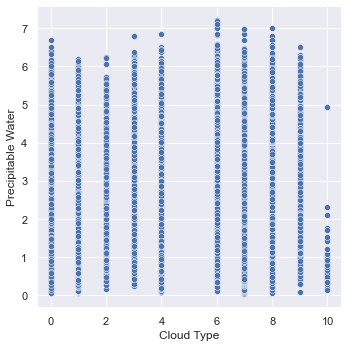

In [79]:
sns.relplot(x='Cloud Type', y='Precipitable Water', data = df_controlled)
plt.xlabel("Cloud Type")
plt.ylabel("Precipitable Water")

Text(18.21, 0.5, 'Precipitable Water')

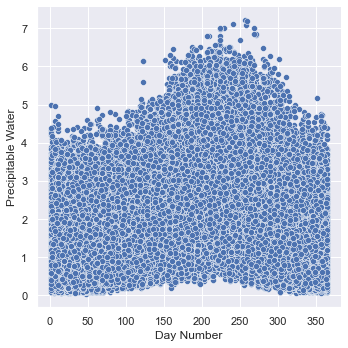

In [80]:
sns.relplot(x='Day Number', y='Precipitable Water', data = df_controlled)
plt.xlabel("Day Number")
plt.ylabel("Precipitable Water")

Text(18.21, 0.5, 'Precipitable Water')

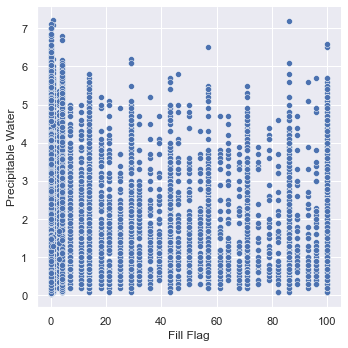

In [81]:
sns.relplot(x='Fill Flag', y='Precipitable Water', data = df_controlled)
plt.xlabel("Fill Flag")
plt.ylabel("Precipitable Water")

Text(18.21, 0.5, 'Precipitable Water')

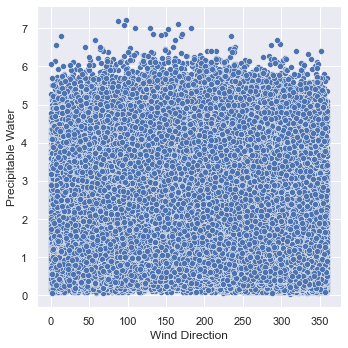

In [82]:
sns.relplot(x='Wind Direction', y='Precipitable Water', data = df_controlled)
plt.xlabel("Wind Direction")
plt.ylabel("Precipitable Water")

Text(18.21, 0.5, 'Precipitable Water')

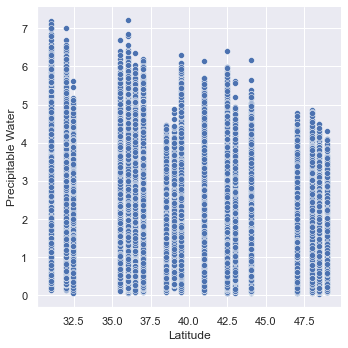

In [83]:
sns.relplot(x='Latitude', y='Precipitable Water', data = df_controlled)
plt.xlabel("Latitude")
plt.ylabel("Precipitable Water")

Text(18.21, 0.5, 'Precipitable Water')

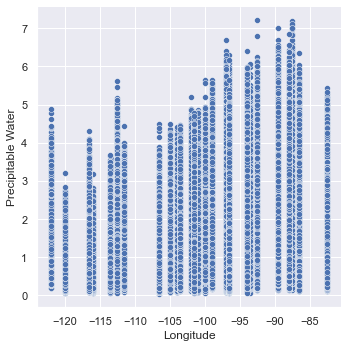

In [84]:
sns.relplot(x='Longitude', y='Precipitable Water', data = df_controlled)
plt.xlabel("Longitude")
plt.ylabel("Precipitable Water")

Text(18.21, 0.5, 'Precipitable Water')

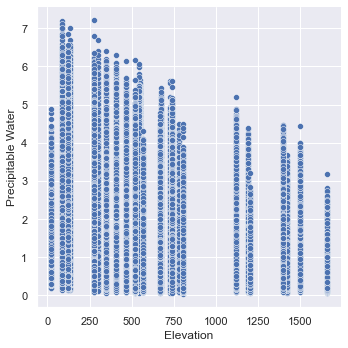

In [85]:
sns.relplot(x='Elevation', y='Precipitable Water', data = df_controlled)
plt.xlabel("Elevation")
plt.ylabel("Precipitable Water")

Text(18.21, 0.5, 'Precipitable Water')

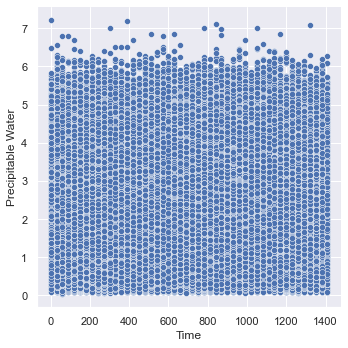

In [86]:
sns.relplot(x='Time', y='Precipitable Water', data = df_controlled)
plt.xlabel("Time")
plt.ylabel("Precipitable Water")

## Model

In [87]:
from sklearn import tree
from sklearn.inspection import PartialDependenceDisplay

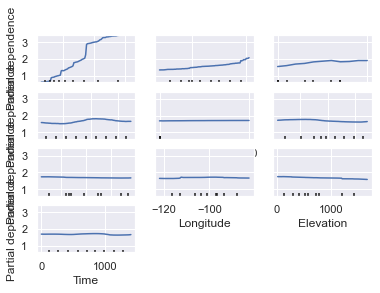

In [88]:
var = ['Specific Humidity', 'Dew Point', 'Cloud Type', 'Day Number', 'Fill Flag', 'Wind Direction', 'Latitude', 'Longitude', 'Elevation', 'Time']
PartialDependenceDisplay.from_estimator(forest_regression_sp, x_train, var, kind='average')

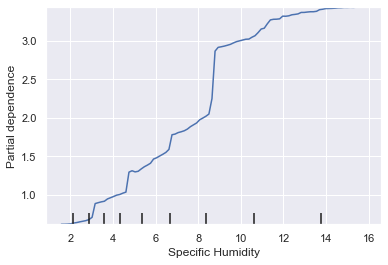

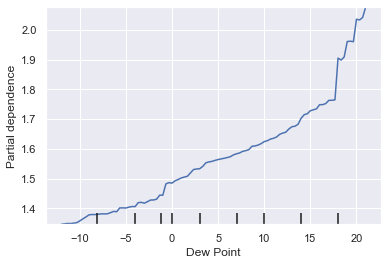

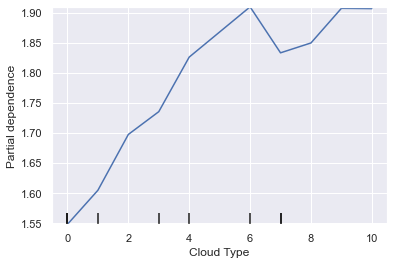

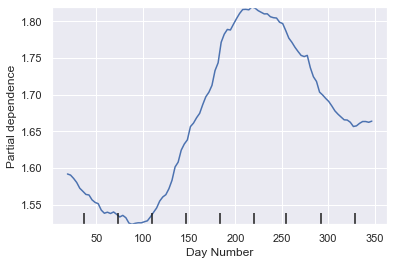

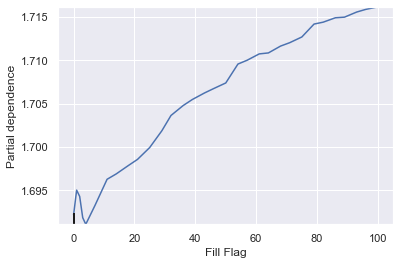

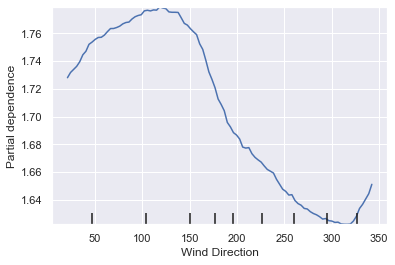

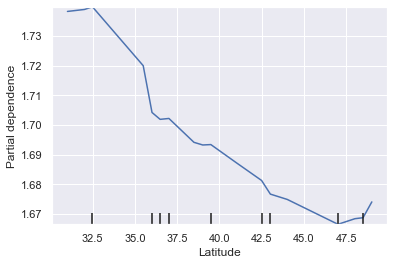

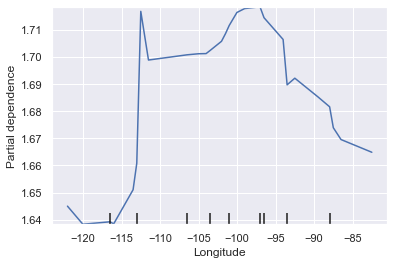

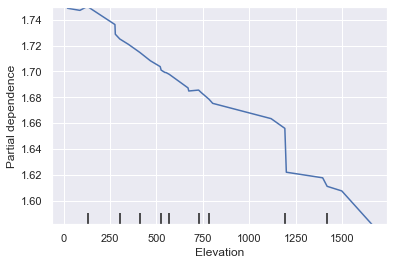

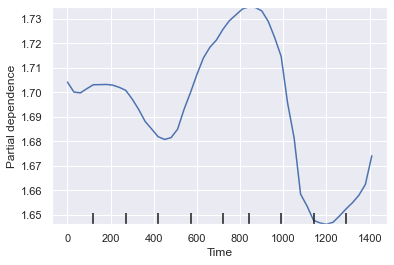

In [89]:
for variable in var:
    PartialDependenceDisplay.from_estimator(forest_regression_sp, x_train, [variable], kind='average')

https://towardsdatascience.com/partial-dependence-plots-with-scikit-learn-966ace4864fc

In [ ]:
import graphviz
from sklearn.tree import export_graphviz

dot_data = export_graphviz(forest_regression_sp.estimators_[99], 
                           feature_names=x_train.columns,
                           class_names=['Precipitable Water'], 
                           filled=True, impurity=True, 
                           rounded=True)

graph = graphviz.Source(dot_data, format='png')
graph

## Map

In [ ]:
import descartes
import geopandas as gpd
from shapely.geometry import Point, Polygon 

### Test Map

In [ ]:
location = pd.DataFrame()

In [ ]:
location_1 = pd.read_csv('random_location_1.csv')
location_2 = pd.read_csv('random_location_2.csv')
location_3 = pd.read_csv('random_location_3.csv')
location_4 = pd.read_csv('random_location_4.csv')
location_5 = pd.read_csv('random_location_5.csv')
location_6 = pd.read_csv('random_location_6.csv')
location_7 = pd.read_csv('random_location_7.csv')
location_8 = pd.read_csv('random_location_8.csv')
location_9 = pd.read_csv('random_location_9.csv')
location_10 = pd.read_csv('random_location_10.csv')

In [ ]:
location_1 = location_1.sample(n=1)
location_2 = location_2.sample(n=1)
location_3 = location_3.sample(n=1)
location_4 = location_4.sample(n=1)
location_5 = location_5.sample(n=1)
location_6 = location_6.sample(n=1)
location_7 = location_7.sample(n=1)
location_8 = location_8.sample(n=1)
location_9 = location_9.sample(n=1)
location_10 = location_10.sample(n=1)

In [ ]:
df_location = pd.concat([location_1, location_2, location_3, location_4, location_5, location_6, location_7, location_8, location_9, location_10])


In [ ]:
location = location.append(df_location)

In [ ]:
location.drop(location.columns.difference(['Latitude','Longitude', 'Elevation']), 1, inplace=True)

In [ ]:
location

In [ ]:
street_map = gpd.read_file('/Users/architg/Desktop/Current Projects/Priority/Data Center Cooling Research/cb_2019_us_region_5m/cb_2019_us_region_5m.shp')


In [ ]:
fig, ax = plt.subplots(figsize=(100,100))
street_map.plot(ax=ax, color='grey')

In [ ]:
geometry = [Point(xy) for xy in zip(location['Longitude'], location['Latitude'])]
crs = {'init':'epsg:4326'}
geo_location = gpd.GeoDataFrame(location, crs=crs, geometry=geometry)

In [ ]:
fig, ax = plt.subplots(figsize=(100,100))
street_map.plot(ax=ax, alpha=0.4, color='grey')
geo_location.geometry.plot(marker='o', color = 'blue', ax = ax, alpha=.5, markersize = 1000)

### Train Map

In [ ]:
train_map = df_controlled.drop(df_controlled.columns.difference(['Latitude','Longitude', 'Elevation']), 1)

In [ ]:
train_map = train_map.drop_duplicates()

In [ ]:
train_geometry = [Point(xy) for xy in zip(train_map['Longitude'], train_map['Latitude'])]
crs = {'init':'epsg:4326'}
train_geo_location = gpd.GeoDataFrame(train_map, crs=crs, geometry=train_geometry)

In [ ]:
fig, ax = plt.subplots(figsize=(100,100))
street_map.plot(ax=ax, alpha=0.4, color='grey')
train_geo_location.geometry.plot(marker='o', color = 'blue', ax = ax, alpha=.5, markersize = 1000)

### Combined

In [ ]:
fig, ax = plt.subplots(figsize=(100,100))
street_map.plot(ax=ax, alpha=0.4, color='grey')
train_geo_location.geometry.plot(marker='o', color = 'blue', ax = ax, alpha=.5, markersize = 500)
geo_location.geometry.plot(marker='^', color = 'red', ax = ax, alpha=.5, markersize = 500)

# Performance

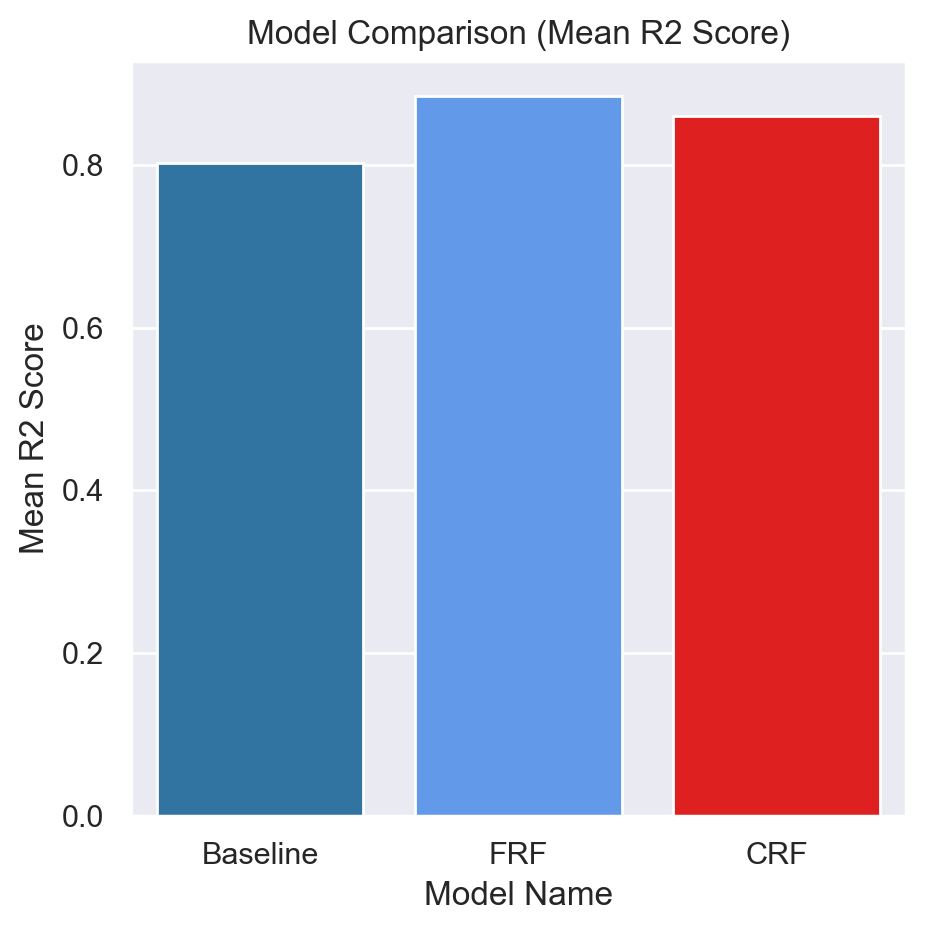

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

# Sample data
model = ["Baseline", "FRF", "CRF"]
mean = [0.8028, 0.8841, 0.8601]
sd = [0.0394, 0.0189, 0.0230]

# Create a figure
plt.figure(figsize=(5, 5), dpi=200)

# Define custom colors for the bars
colors = ['#1f77b4', '#4d94ff', 'red']  

# Create a bar plot with custom colors
sns.set(style="darkgrid")
sns.barplot(x=model, y=mean, palette=colors)

# Set plot title and axis labels
plt.title("Model Comparison (Mean R2 Score)")
plt.xlabel("Model Name")
plt.ylabel("Mean R2 Score")

# Save the plot with a transparent background
plt.savefig("Mean_R2.png", transparent=True)

# Show the plot
plt.show()

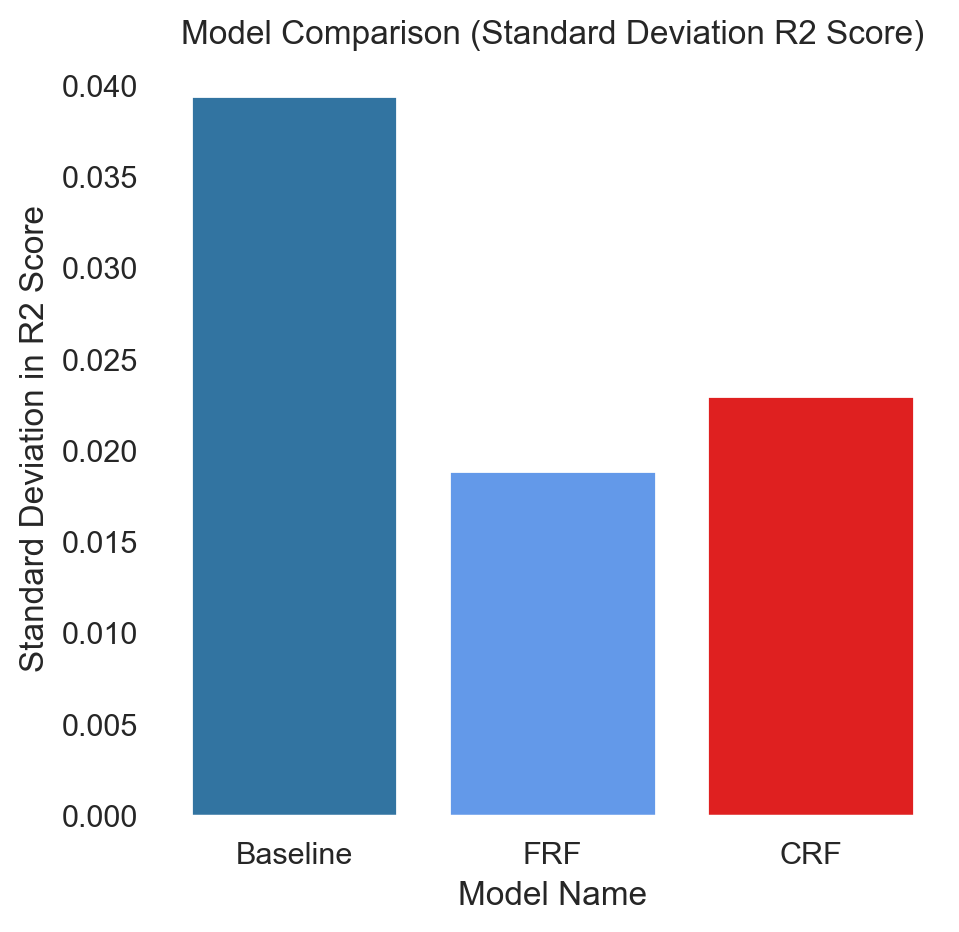

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

# Sample data
model = ["Baseline", "FRF", "CRF"]
sd = [0.0394, 0.0189, 0.0230]

# Create a figure
plt.figure(figsize=(5, 5), dpi=200)

# Define custom colors for the bars
colors = ['#1f77b4', '#4d94ff', 'red']  # Use different shades of blue for "Baseline" and "FRF"

# Create a bar plot with custom colors
sns.set(style="darkgrid")
ax = sns.barplot(x=model, y=sd, palette=colors)

# Set the background of the axes to be transparent
ax.set_facecolor('none')

# Set plot title and axis labels
plt.title("Model Comparison (Standard Deviation R2 Score)")
plt.xlabel("Model Name")
plt.ylabel("Standard Deviation in R2 Score")

# Save the plot with a transparent background
plt.savefig("SD_R2.png", transparent=True, bbox_inches='tight')

# Show the plot
plt.show()